In [1]:
BATCH_SIZE = 32
MAX_LEN = 716
EMBEDDING_DIM = 300
NUM_CLASSES = 9
NUM_TRAIN = 5893
NUM_TEST = 1474

In [26]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN], dtype=tf.float32),
            'Y': tf.FixedLenFeature((NUM_CLASSES,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [27]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN])
    
    return X, Y

In [28]:
%%time

x_train, y_train = iterator('train_with_sp.tfrecord', NUM_TRAIN)
x_test, y_test = iterator('test_with_sp.tfrecord', NUM_TEST)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 3.32 s, sys: 463 ms, total: 3.78 s
Wall time: 2.83 s


In [29]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 716), (5893, 9), (1474, 716), (1474, 9))

In [30]:
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 10

In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(8001, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Conv1D(filters,
                kernel_size,
                padding='valid',
                activation='relu',
                strides=1,))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, 
                activation='relu'
               ))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 716, 300)          2400300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 714, 256)          230656    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 2313      
Total params: 2,699,061
Trainable params: 2,699,061
Non-trainable params: 0
_________________________________________________________________


In [35]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [36]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/10
5893/5893 [==============================] - 3s 438us/step - loss: 0.8079 - acc: 0.7636 - val_loss: 0.2394 - val_acc: 0.9315
Epoch 2/10
5893/5893 [==============================] - 2s 264us/step - loss: 0.1322 - acc: 0.9606 - val_loss: 0.1626 - val_acc: 0.9525
Epoch 3/10
5893/5893 [==============================] - 2s 263us/step - loss: 0.0381 - acc: 0.9905 - val_loss: 0.1380 - val_acc: 0.9600
Epoch 4/10
5893/5893 [==============================] - 2s 263us/step - loss: 0.0114 - acc: 0.9986 - val_loss: 0.1332 - val_acc: 0.9607
Epoch 5/10
5893/5893 [==============================] - 2s 262us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.1381 - val_acc: 0.9579
Epoch 6/10
5893/5893 [==============================] - 2s 263us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.1374 - val_acc: 0.9620
Epoch 7/10
5893/5893 [==============================] - 2s 262us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1414 - val_acc: 0.9593


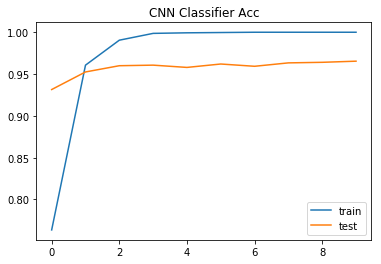

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

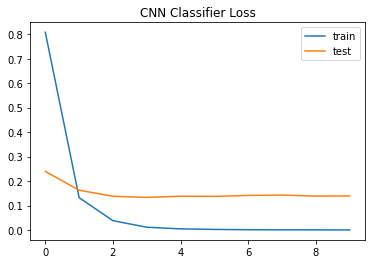

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [39]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.965     0.937     0.951       175
  it-life-hack      0.962     0.994     0.978       154
 kaden-channel      1.000     0.982     0.991       167
livedoor-homme      0.903     0.816     0.857       114
   movie-enter      0.956     0.994     0.975       174
        peachy      0.937     0.962     0.949       184
          smax      0.989     1.000     0.995       186
  sports-watch      0.975     0.975     0.975       163
    topic-news      0.981     0.981     0.981       157

     micro avg      0.965     0.965     0.965      1474
     macro avg      0.963     0.960     0.961      1474
  weighted avg      0.965     0.965     0.965      1474



Normalized confusion matrix
[[0.937 0.    0.    0.029 0.011 0.023 0.    0.    0.   ]
 [0.    0.994 0.    0.    0.    0.    0.006 0.    0.   ]
 [0.    0.    0.982 0.    0.    0.006 0.006 0.006 0.   ]
 [0.026 0.053 0.    0.816 0.044 0.053 0.    0.009 0.   ]
 [0.    0.    0.    0.    0.994 0.006 0.    0.    0.   ]
 [0.016 0.    0.    0.016 0.005 0.962 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.006 0.    0.    0.    0.975 0.018]
 [0.    0.    0.    0.006 0.    0.    0.    0.013 0.981]]


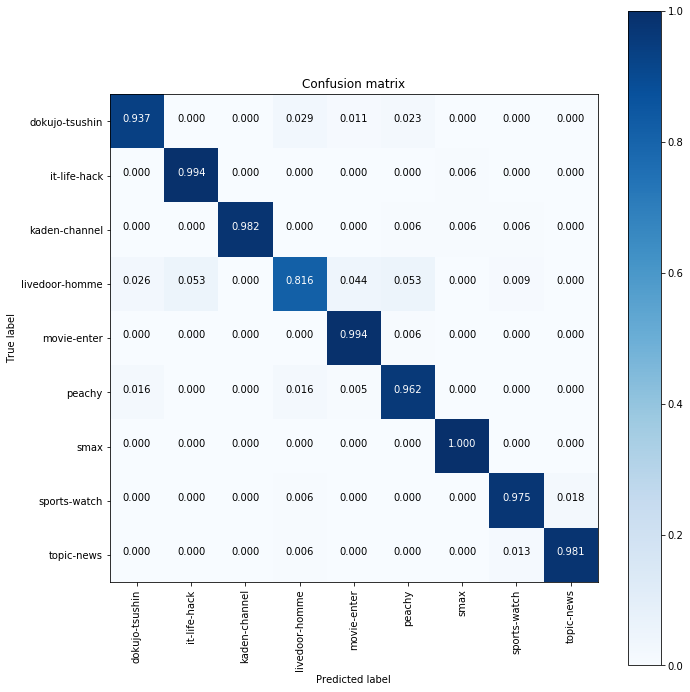

In [41]:
import sys
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)